In [11]:
import numpy as np
from matplotlib import pyplot as plt
# ----- Cord for importing .ipynb file as module -----
import sys  
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
# ----------------------------------------------------
from activations import *
from loss_functions import *
from optimizer import *
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

class nn_module:
    def __init__(self, layers_dims, init_weight_range):
        self.params = {}
        self.grads = {}
        self.outputs = {}
        self.L = len(layers_dims)
        for l in range(1, self.L):
            W = np.random.uniform(
                low = - init_weight_range,
                high = init_weight_range,
                size = (layers_dims[l-1], layers_dims[l])
            )
            b = np.zeros((1, layers_dims[l]))
            self.params['W' + str(l)] = W
            self.params['b' + str(l)] = b
            
    def forward_propagate(self, X, activations):
        f = activations['hidden_activation']
        g = activations['output_activation']
        # Input Layer
        self.outputs['A0'] = X
        A = self.outputs['A0']
        # Hidden Layers
        for l in range(1, self.L - 1):
            W = self.params['W' + str(l)]
            b = self.params['b' + str(l)]
            Z = np.dot(A, W) + b
            A = f(Z)
            self.outputs['Z' + str(l)] = Z
            self.outputs['A' + str(l)] = A
        # Output Layer
        W = self.params['W' + str(self.L - 1)]
        b = self.params['b' + str(self.L - 1)]
        Z = np.dot(A, W) + b
        A = g(Z)
        self.outputs['Z' + str(self.L - 1)] = Z
        self.outputs['A' + str(self.L - 1)] = A
        return A
    
    def back_propagate(self, dA, activations):
        N = dA.shape[0]
        df = activations['derivative_hidden_activation']
        dg = activations['derivative_output_activation']
        # Output Layer
        Z = self.outputs['Z' + str(self.L - 1)]
        A_prev = self.outputs['A' + str(self.L - 2)]
        dZ = dA * dg(Z)
        dW = np.dot(A_prev.T, dZ)
        db = np.sum(dZ, axis = 0, keepdims = True)
        # --------------------------------------------------------------
        assert(dW.shape == self.params['W' + str(self.L - 1)].shape)
        assert(db.shape == self.params['b' + str(self.L - 1)].shape)
        # --------------------------------------------------------------
        self.grads['W' + str(self.L - 1)] = dW
        self.grads['b' + str(self.L - 1)] = db
        W = self.params['W' + str(self.L - 1)]
        dA = np.dot(dZ, W.T)
        # Hidden Layers
        for l in reversed(range(1, self.L - 1)):
            Z = self.outputs['Z' + str(l)]
            A_prev = self.outputs['A' + str(l - 1)]
            dZ = dA * df(Z)
            dW = np.dot(A_prev.T, dZ)
            db = np.sum(dZ, axis = 0, keepdims = True)
            # ----------------------------------------------------------
            assert(dW.shape == self.params['W' + str(l)].shape)
            assert(db.shape == self.params['b' + str(l)].shape)
            # ----------------------------------------------------------
            self.grads['W' + str(l)] = dW
            self.grads['b' + str(l)] = db
            W = self.params['W' + str(l)]
            dA = np.dot(dZ, W.T)

1 0.7219853116605398
1000 0.5458060827209446
2000 0.1866981759240968
3000 0.08420525013140491
4000 0.045489836187224866
5000 0.026764060211015052
6000 0.016473157062235663
7000 0.010402292106660136
8000 0.006669683658019974
8661 0.004998776597882014
----- Learning End -----


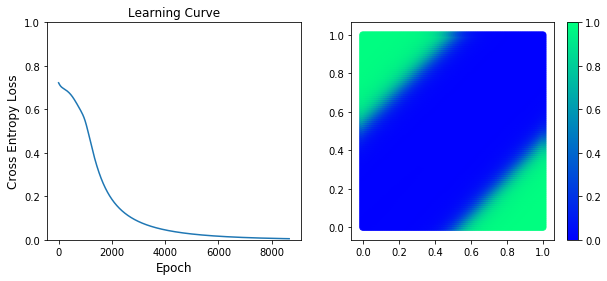

In [12]:
if __name__=='__main__':
    # ------< Hyperparameter >------
    epochs = 10000
    error_boundary = 5e-3
    structure = [2, 2, 1]
    init_weight_range = 1.0
    nn = nn_module(structure, init_weight_range)
    optimizer = Adam(nn)
    """
    Choose activate functions of hidden layers and output layer.
    Sigmoid, ReLU, tanh can be choosen for activate functions.
    name_haf: Name of Hidden-layers Activate Function
    name_oaf: Name of Output-layer Activate Function
    """
    activations = return_activations(
        name_haf = 'tanh',
        name_oaf = 'sigmoid'
    )
    
    # ------< Training and Teaching Data >------
    X = np.array([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 1.0]])
    Y = np.array([[0.0], [1.0], [1.0], [0.0]])
    
    # ------< Learning Data >------
    loss = []
    training_data_indexes = np.arange(len(X))
    for epoch in range(1, epochs+1):
        y_pred = nn.forward_propagate(X, activations)
        loss_epoch, delta = BCEL(y_pred, Y)
        loss.append(loss_epoch)
        nn.back_propagate(delta, activations)
        optimizer.update_params()
        if epoch % 1000 == 0 or epoch == 1:
            print(epoch, loss[-1])
#             print(nn.params['vW1'])
        if loss[-1] < error_boundary:
            print(epoch, loss[-1])
            print('----- Learning End -----')
            break

    # ------< Plot Learning Result >------
    x = np.arange(0.0, 1.01, 0.01)
    y = np.arange(0.0, 1.01, 0.01)
    z = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            inputs = np.array([[x[i], y[j]]])
            outputs = nn.forward_propagate(inputs, activations)
            z[i][j] = np.squeeze(outputs)
    x, y = np.meshgrid(x, y)

    plt.figure(figsize = (10, 4))
    plt.subplot(121)
    plt.plot(np.arange(len(loss)), loss)
    plt.title('Learning Curve')
    plt.xlabel('Epoch', fontsize = 12)
    plt.ylabel('Cross Entropy Loss', fontsize = 12)
    plt.ylim(0.0, 1.0)

    plt.subplot(122)
    plt.scatter(x, y, c = z, cmap = 'winter', vmin = 0, vmax = 1)
    plt.colorbar()

Epoch: 1   Train Loss: 0.9257   Test Loss: 0.9217
Epoch: 100   Train Loss: 0.0016   Test Loss: 0.0019
Epoch: 200   Train Loss: 0.0012   Test Loss: 0.0016
Epoch: 300   Train Loss: 0.0012   Test Loss: 0.0017
Epoch: 400   Train Loss: 0.0012   Test Loss: 0.0016
Epoch: 500   Train Loss: 0.0009   Test Loss: 0.0016
Epoch: 600   Train Loss: 0.0010   Test Loss: 0.0015
Epoch: 700   Train Loss: 0.0010   Test Loss: 0.0015
Epoch: 800   Train Loss: 0.0009   Test Loss: 0.0014
Epoch: 900   Train Loss: 0.0008   Test Loss: 0.0014
Epoch: 1000   Train Loss: 0.0008   Test Loss: 0.0014


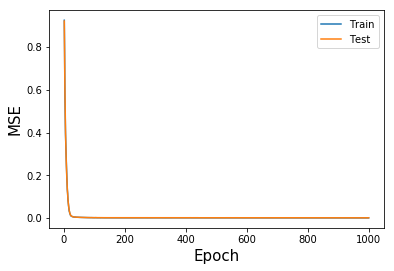

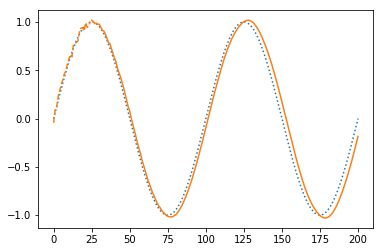

In [31]:
# -------------------< Toy Problem(Predict sin wave) >-------------------
if  __name__ == '__main__':
    def toy_problem(T = 100, A = 0.05):
        x = np.arange(0, 2 * T + 1)
        noise = A * np.random.uniform(low = - 1.0, high = 1.0, size = len(x))
        return np.sin(2.0 * np.pi * x / T) + noise
    
    # Prepare sin wave data
    T = 100
    f = toy_problem(T)
    seq_len = 25
    data = []
    target = []
    for t in range(2 * T - seq_len + 1):
        data.append(f[t: t + seq_len])
        target.append(f[t + seq_len])
    
    # Set up networks
    layer_dims = [seq_len, 20, 1]
    init_weight_range = 0.3
    nn = nn_module(layer_dims, init_weight_range)
    activations = return_activations(name_haf = 'tanh', name_oaf = 'linear')
#     lr = 0.1
#     optimizer = SGD(rnn, lr)
    optimizer = Adam(nn)

    # Create train and teach data
    X = np.array(data).reshape(len(data), seq_len)
    Y = np.array(target).reshape(len(target), layer_dims[-1])
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
    
    # Learning data
    epoches = 1000
    batch_size = 32
    Loss_train = []
    Loss_test = []
    n_batches = len(X_train) // batch_size
    for epoch in range(1, epoches + 1):
        loss_list = []
        X_train, Y_train = shuffle(X_train, Y_train)
        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size
            nn.forward_propagate(X_train[start:end], activations)
            loss_list.append(nn.compute_loss(Y_train[start:end]))
            nn.back_propagate(Y_train[start:end], activations)
            optimizer.update_params()
        Loss_train.append(np.mean(loss_list))
        nn.forward_propagate(X_test, activations)
        Loss_test.append(nn.compute_loss(Y_test))
        if epoch % 100 == 0 or epoch == 1:
            print('Epoch:', epoch,
                  '  Train Loss:', '{:.4f}'.format(Loss_train[-1]),
                  '  Test Loss:', '{:.4f}'.format(Loss_test[-1])
                 )
    
    # Plot Learning Curve
    plt.figure()
    plt.plot(np.arange(epoches) + 1, Loss_train, label='Train')
    plt.plot(np.arange(epoches) + 1, Loss_test, label='Test')
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('MSE', fontsize=15)
    plt.legend()
    
    # Plot predicted sin wave
    Z = X[:1]
    original = [f[t] for t in range(seq_len)]
    predicted = [None for t in range(seq_len)]
    for t in range(2 * T - seq_len + 1):
        z = Z[-1:]
        y_pred = nn.test_nn(z, activations)
        sequence = np.concatenate(
            (z.reshape(1, seq_len)[:, 1:], y_pred), axis=1
        ).reshape(1, seq_len)
        Z = np.append(Z, sequence, axis=0)
        predicted.append(float(y_pred))
    plt.figure()
    plt.plot(toy_problem(T, A=0), linestyle='dotted', color='tab:blue')
    plt.plot(original, linestyle='dashed', color='tab:orange')
    plt.plot(predicted, color='tab:orange')